# Wstępnie trenowana konwolucyjna sieć neuronowa (ang. Pre-trained convolutional neural network) MobileNet V2 w analizie czerniaka

## Tworzymy model

In [1]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import tensorflow_hub as hub
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ioe0i0u9 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Ładujemy dane do trenowania i walidacji.

In [2]:
datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
training_set = datagen.flow_from_directory('/big-data',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='categorical',
                                           subset='training')
validation_set = datagen.flow_from_directory('/big-data',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='categorical',
                                           subset='validation')

Found 43922 images belonging to 9 classes.
Found 10975 images belonging to 9 classes.


Zapisujemy ilość diagnoz do zmiennej.

In [3]:
DIAGNOSIS_NUMBER = len(training_set.class_indices)

Budujemy model - sieć konwolucyjną z 3 warstwami konwolucyjnymi (ang. convolutional layer) i 2 warstwami gęstymi (ang. dense layer).

In [4]:
model = Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", output_shape=[1280],
                   trainable=False),
    Dense(DIAGNOSIS_NUMBER, activation='softmax')
])
model.build([None, 224, 224, 3])

In [5]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Dodajemy funkcjonalność zbierania danych o wydajności modelu do Tensorboard.

In [6]:
log_dir = '../logs/fit/' + datetime.datetime.now().strftime('mobilenet_v2')
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

Dodajemy funkcjonalność zapisywania modelu w trakcie jego trenowania. Zwóćmy uwagę, że zapisywany jest tylko jeden model i lepszy nadpisuje gorszy.

In [7]:
checkpoint_path = 'checkpoints/mobilenet_v2.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto')

Dodajemy funkcjonalność zatrzymania trenowania modelu, jeśli nie będzie poprawy w ciągu 10 epoch.

In [8]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=10, restore_best_weights=True)

Trenujemy model.

In [9]:
model.fit(training_set, validation_data=validation_set, epochs=200, callbacks=[tensorboard_callback,
                                                                               checkpoint_callback,
                                                                               early_stop_callback])

Epoch 1/200
1373/1373 [==============================] - 4746s 3s/step - loss: 0.7752 - accuracy: 0.7233 - val_loss: 0.7847 - val_accuracy: 0.7521

Epoch 00001: val_loss improved from inf to 0.78470, saving model to checkpoints/mobilenet_v2.ckpt
INFO:tensorflow:Assets written to: checkpoints/mobilenet_v2.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/mobilenet_v2.ckpt/assets


Epoch 2/200
1373/1373 [==============================] - 4729s 3s/step - loss: 0.6614 - accuracy: 0.7620 - val_loss: 0.8082 - val_accuracy: 0.7549

Epoch 00002: val_loss did not improve from 0.78470
Epoch 3/200
1373/1373 [==============================] - 4731s 3s/step - loss: 0.6258 - accuracy: 0.7742 - val_loss: 0.7995 - val_accuracy: 0.7514

Epoch 00003: val_loss did not improve from 0.78470
Epoch 4/200
1373/1373 [==============================] - 4738s 3s/step - loss: 0.6031 - accuracy: 0.7823 - val_loss: 0.7695 - val_accuracy: 0.7850

Epoch 00004: val_loss improved from 0.78470 to 0.76953, saving model to checkpoints/mobilenet_v2.ckpt
INFO:tensorflow:Assets written to: checkpoints/mobilenet_v2.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/mobilenet_v2.ckpt/assets


Epoch 5/200
1373/1373 [==============================] - 4733s 3s/step - loss: 0.5903 - accuracy: 0.7848 - val_loss: 0.7830 - val_accuracy: 0.7667

Epoch 00005: val_loss did not improve from 0.76953
Epoch 6/200
1373/1373 [==============================] - 4730s 3s/step - loss: 0.5772 - accuracy: 0.7881 - val_loss: 0.7939 - val_accuracy: 0.7726

Epoch 00006: val_loss did not improve from 0.76953
Epoch 7/200
1373/1373 [==============================] - 4742s 3s/step - loss: 0.5655 - accuracy: 0.7942 - val_loss: 0.7936 - val_accuracy: 0.7504

Epoch 00007: val_loss did not improve from 0.76953
Epoch 8/200
1373/1373 [==============================] - 4738s 3s/step - loss: 0.5607 - accuracy: 0.7946 - val_loss: 0.7843 - val_accuracy: 0.7708

Epoch 00008: val_loss did not improve from 0.76953
Epoch 9/200
1373/1373 [==============================] - 4733s 3s/step - loss: 0.5545 - accuracy: 0.7975 - val_loss: 0.8501 - val_accuracy: 0.7664

Epoch 00009: val_loss did not improve from 0.76953
Epoch

## Szacujemy dokładność modelu

Ładujemy dane do testowania.

In [10]:
datagen = ImageDataGenerator(rescale=1. / 255)
testing_set = datagen.flow_from_directory('/big-data-test',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='categorical')

Found 2889 images belonging to 9 classes.


Pobieramy diagnozy z danych testowych.

In [11]:
true_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

Prognozujemy diagnozy dla każdego obrazu.

In [12]:
predicted_labels = model.predict(testing_set)

Obliczamy punkty wykresu ROC (Receiver operating characteristic) i metrykę AUC (Area under the curve).

In [13]:
fpr = dict()
tpr = dict()
auc_metric = dict()

diagnosis_index_dict = {v: k for k, v in training_set.class_indices.items()}

for i in range(DIAGNOSIS_NUMBER):
    diagnosis = diagnosis_index_dict[i]
    fpr[diagnosis], tpr[diagnosis], _ = roc_curve(true_labels[:, i], predicted_labels[:, i])
    auc_metric[diagnosis] = auc(fpr[diagnosis], tpr[diagnosis])

Rysujemy wykres ROC (Receiver operating characteristic).

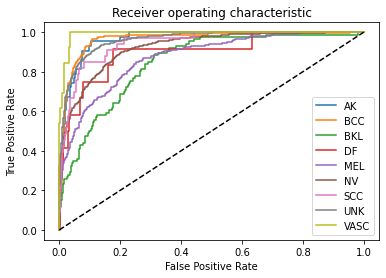

In [14]:
for diagnosis in training_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Metryki AUC do każdej diagnozy.

In [15]:
auc_metric

{'AK': 0.9657618199349557,
 'BCC': 0.9645587694437835,
 'BKL': 0.8480116818359067,
 'DF': 0.9001853782875681,
 'MEL': 0.873752729370082,
 'NV': 0.9246568525613461,
 'SCC': 0.9455373058314235,
 'UNK': 0.9629991289798354,
 'VASC': 0.9915748368460469}